In [19]:
import configs.pyroot_config as pyroot_config
import os
from torch.utils.data import default_collate
import torch
from src.data.mice_dataset import MouseSniffingVideoDatasetMultipleFramesLabeled
from src.data.mice_dataset_factory import create_dataset, trails_split
import torchvision.transforms.v2 as tt
from models.lightning_module import DeepSniff
from models.models import MobileNetV3
from pytorch_lightning.callbacks import *
import random

config_paths = pyroot_config.ConfigPaths()

### TRANSFORMS
transforms = tt.Compose([
                        tt.Resize(224, antialias=True),
                        tt.ConvertImageDtype(torch.float16),
                        tt.Normalize(mean=[0.36], std=[0.2])])


transforms_val = tt.Compose([
                            #resize to 224x224
                            tt.Resize(224, antialias=True),
                            tt.ConvertImageDtype(torch.float16),
                            tt.Normalize(mean=[0.36], std=[0.2])])

### DATASET

data_dir = config_paths.data_processed / 'sniff-training-dataset'

#list all subdirs
trails = [f.path for f in os.scandir(data_dir) if f.is_dir()]
#print(trails)

#train val test 0.9, 0.1, 0.1
trails = random.sample(trails, len(trails))
train_trails = trails[:int(0.8*len(trails))]
val_trails = trails[int(0.8*len(trails)):int(0.9*len(trails))]
test_trails = trails[int(0.9*len(trails)):]

#print len
print(len(train_trails), len(val_trails), len(test_trails))


window_size = 5         # Must be odd number
signal_window_size = 1  # Must be odd number

train_datasets = []
for trail in train_trails:
    print(trail)
    train_datasets.append(MouseSniffingVideoDatasetMultipleFramesLabeled(root_dir=trail,
                                                                        video_path='cropped_frames',
                                                                        signal_path='breathing_onsets.txt',
                                                                        window_size=window_size,
                                                                        signal_window_size=signal_window_size,
                                                                        transforms=transforms,
                                                                        #loading_transforms=None,
                                                                        load_in_memory=True))
train_dataset = torch.utils.data.ConcatDataset(train_datasets)

# val_datasets = []
# for trail in val_trails:
#     val_datasets.append(MouseSniffingVideoDatasetMultipleFramesLabeled(root_dir=trail,
#                                                                         video_path='cropped_frames',
#                                                                         signal_path='breathing_onsets.txt',
#                                                                         window_size=window_size,
#                                                                         signal_window_size=signal_window_size,
#                                                                         transforms=transforms_val,
#                                                                         #loading_transforms=None,
#                                                                         load_in_memory=True))
# val_dataset = torch.utils.data.ConcatDataset(val_datasets)

# test_datasets = []
# for trail in test_trails:
#     test_datasets.append(MouseSniffingVideoDatasetMultipleFramesLabeled(root_dir=trail,
#                                                                         video_path='cropped_frames',
#                                                                         signal_path='breathing_onsets.txt',
#                                                                         window_size=window_size,
#                                                                         signal_window_size=signal_window_size,
#                                                                         transforms=transforms_val,
#                                                                         #loading_transforms=None,
#                                                                         load_in_memory=True))
# test_dataset = torch.utils.data.ConcatDataset(test_datasets)



# def collate_fn(batch):
#     batch = default_collate(batch)
#     batch[0] = batch[0].squeeze()
#     return batch



# ## MODEL

# weights = None 
# n_input_channels = window_size
# output_dim = signal_window_size

# network = MobileNetV3(n_input_channels=n_input_channels, output_dim=output_dim)
# loss = torch.nn.BCELoss()
# optimizer = torch.optim.AdamW(network.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1.0e-08, weight_decay=0.01)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.000003, last_epoch=-1, verbose=True)
# model = DeepSniff(network, loss, optimizer, scheduler)

# #subsets of datasetes
# batch_size = 256

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=10, collate_fn=collate_fn)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=10, collate_fn=collate_fn)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=10, collate_fn=collate_fn)


# sample = next(iter(train_loader))
# print(sample[0].shape, sample[1].shape)

# print(sample[0])
# print(train_dataset[0]) 

32 4 4
data/processed/sniff-training-dataset/230825_RDP105_0
data/processed/sniff-training-dataset/230816_RDP129_3
data/processed/sniff-training-dataset/230217_LK031_6
data/processed/sniff-training-dataset/230829_RDP129_10
data/processed/sniff-training-dataset/240422_RDP146_2
data/processed/sniff-training-dataset/220610_KK021_9
data/processed/sniff-training-dataset/230822_RDP129_7
data/processed/sniff-training-dataset/221129_RDP086_6
data/processed/sniff-training-dataset/220817_ES022_0
data/processed/sniff-training-dataset/220727_LK013_4
data/processed/sniff-training-dataset/220223_RDP043_4
data/processed/sniff-training-dataset/230319_KK048_9
data/processed/sniff-training-dataset/231005_KK063_4
data/processed/sniff-training-dataset/230216_LK031_6
data/processed/sniff-training-dataset/230829_RDP105_6
data/processed/sniff-training-dataset/220820_ES022_6
data/processed/sniff-training-dataset/231010_KK063_1
data/processed/sniff-training-dataset/231002_KK063_6
data/processed/sniff-training-

(600, 224, 224)


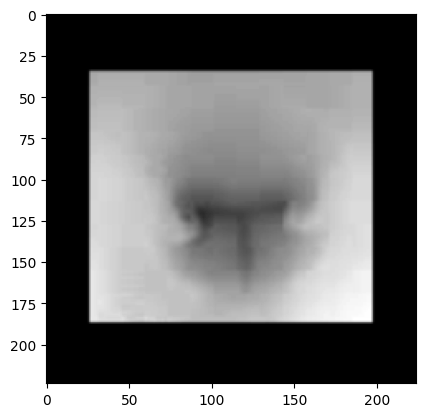

In [22]:
import matplotlib.pyplot as plt
sample = train_dataset[0]
plt.imshow(sample[0][0][0].numpy().squeeze(), cmap='gray')

#sample first 100 frames and make a video
import cv2
import numpy as np
import os

frames = []
for i in range(600):
    frame = train_dataset[i][0][0][0].numpy().squeeze()
    frame = frame * 0.2 + 0.36
    frame = (frame * 255).astype(np.uint8)  # Convert to CV_8U
    frames.append(frame)

frames = np.array(frames)
#denormalize
print(frames.shape)

out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, (224, 224), isColor=False)
for i in range(len(frames)):
    out.write(frames[i])
out.release()

#play video in ipynb
from IPython.display import Video

Video("output.avi", width=600, height=600)

